# Spring PV field albedo, from fit with sine curve

Helpful website:
https://www.suncalc.org/#/29.7692,34.9695,8/2023.03.21/12:21/1/3

Highest solar elevation on:
- 21 March: 11:47 AM (local time = UTC + 2), i.e. 11:47 Israel winter time
- 21 Sept: 12:33 AM (local time = UTC + 3), i.e. 11:33 Israel winter time

Therefore, the 11:30-12:00 measurement period will be used as the maximum solar elevation throughout the year, or more precisely 11:45

In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.optimize import curve_fit

from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format

In [2]:
# Data location
project_path = './'
data_path = project_path + '../data/'

# Input path
percentage_fn = data_path + 'temperature_by_element.csv'
ketura_fn     = data_path + 'Ketura_all_corr.csv'
yatir_fn      = project_path + '../../data/towerSAS/Yatir_2000-2020.csv'
yotvata_fn    = data_path + 'Yotvata/'

# Output path
graphs_path = project_path + '../graphs/'
output_path = project_path + '../data/'

# Constants
albedo_pv   = 0.05
panel_angle = 30

pv_percent = 51

In [30]:
def load_tower(fn, silent=False):
    if (not silent):
        print('  -', fn.split('/')[-1])
    temp = pd.read_csv(fn, index_col=None)
    temp.rename({'date_mid_hour': 'DateTime'}, axis=1, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%d%b%y:%H:%M')
    # Remove obsolete columns
    temp.drop(['year','date','DOY','month','weekNo','mid_hour','mmyy','Bat_V','Hum_AC'], axis=1, inplace=True)
    if (not silent): print("    ", '100.0 %\t', fn.split('/')[-1])
    return(temp)

def load_truck(fn, index_col=False, silent=False):
    if (not silent):
        print('  -', fn.split('/')[-1])
    temp = pd.read_csv(fn, index_col=index_col)
    temp.rename(columns={'date_time': 'DateTime'}, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S')
    temp['DateTime'] = temp['DateTime'] + pd.Timedelta(minutes=15)
    return(temp)

def load_percentage(fn, silent=False):
    if (not silent): print('  -', fn.split('/')[-1])
    temp = pd.read_csv(fn)
    
    temp.rename(columns={'date_time': 'DateTime'}, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S')
    #temp['DateTime'] = temp['DateTime'] + pd.Timedelta(minutes=15)
    # Move timestamp to front
    col = temp.pop('DateTime')
    temp.insert(0, col.name, col, allow_duplicates=True)
    
    # Remove obsolete columns
    temp.drop(['Unnamed: 0','flight'], axis=1, inplace=True)
    # Change to wide format
    wide = pd.pivot(temp, index='DateTime', columns='label', values='coverage_percent')
    wide.reset_index(inplace=True)
    
    # Normalise the % to 100%, because sometimes it only reaches 96% total
    wide.loc[wide['sun'].isna(), 'sun'] = 0
    wide['total'] = wide['panel'] + wide['shadow'] + wide['soil'] + wide['sun']
    wide['sun']    = wide['sun'] * 100 / wide['total']
    wide['panel']  = wide['panel'] * 100 / wide['total']
    wide['shadow'] = wide['shadow'] * 100 / wide['total']
    wide['soil']   = wide['soil'] * 100 / wide['total']
    wide.drop(['total'], axis=1, inplace=True)
    
    return(wide)

def load_meteo_stn(directory, silent=False):
    if (not silent):
        print('  - Meteo station:')
        
    file_list = sorted(glob.glob(directory + '**/*.csv', recursive=True))
    data_list = []
    for idx, filename in enumerate(file_list):
        print('    -', filename.split('/')[-1])
        temp = pd.read_csv(filename)
        data_list.append(temp)
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    # Fix problems
    df.columns = ['station','DateTime', 'Eg_Wm2', 'RH_perc', 'Ta_C', 'u_ms']
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%d/%m/%Y %H:%M')
    # Convert to numbers
    df['Eg_Wm2'] = pd.to_numeric(df['Eg_Wm2'], errors='coerce')
    df['RH_perc'] = pd.to_numeric(df['RH_perc'], errors='coerce')
    df['Ta_C'] = pd.to_numeric(df['Ta_C'], errors='coerce')
    df['u_ms'] = pd.to_numeric(df['u_ms'], errors='coerce')
    # Average 10min Yotvata data to half-hours
    df = df.resample('30min', on='DateTime').mean()
    df.reset_index(inplace=True)
    df['DateTime'] = df['DateTime'] + pd.Timedelta(minutes=15)
    return(df)

def add_ecosystem(df):
    df = df.copy()
    # Add ecosystem
    df['Ecosystem'] = np.nan
    df.loc[(df['DateTime'] > '2018-03-17') & (df['DateTime'] < '2018-03-22'), 'Ecosystem'] = 'Desert background'
    df.loc[(df['DateTime'] > '2018-03-21') & (df['DateTime'] < '2018-03-28'), 'Ecosystem'] = 'PV field'
    
    df.loc[(df['DateTime'] > '2018-10-15') & (df['DateTime'] < '2018-10-25'), 'Ecosystem'] = 'Desert background'
    df.loc[(df['DateTime'] > '2018-10-23') & (df['DateTime'] < '2018-11-01'), 'Ecosystem'] = 'PV field'
    
    df.loc[(df['DateTime'] > '2019-07-08') & (df['DateTime'] < '2019-07-17'), 'Ecosystem'] = 'Desert background'
    df.loc[(df['DateTime'] > '2019-07-15') & (df['DateTime'] < '2019-07-25'), 'Ecosystem'] = 'PV field'
    # Season
    df['Season'] = np.nan
    df.loc[(df['DateTime'] > '2018-03-17') & (df['DateTime'] < '2018-03-28'), 'Season'] = 'Spring'
    df.loc[(df['DateTime'] > '2018-10-15') & (df['DateTime'] < '2018-11-01'), 'Season'] = 'Autumn'
    df.loc[(df['DateTime'] > '2019-07-08') & (df['DateTime'] < '2019-07-25'), 'Season'] = 'Summer'
    
    # Create day identifier
    df['time'] = df['DateTime'].dt.strftime('%H:%M')
    # shift column 'timestamp' to first position
    col = df.pop('time')
    df.insert(0, col.name, col, allow_duplicates=True)
    col = df.pop('Ecosystem')
    df.insert(0, col.name, col, allow_duplicates=True)
    col = df.pop('Season')
    df.insert(0, col.name, col, allow_duplicates=True)
    col = df.pop('DateTime')
    df.insert(0, col.name, col, allow_duplicates=True)
    return(df)

In [31]:
print('Loading data...')

ketura_df = load_truck(ketura_fn)
ketura_df = add_ecosystem(ketura_df)

meteo_stn = load_meteo_stn(yotvata_fn)

perc_df = load_percentage(percentage_fn)
perc_df = add_ecosystem(perc_df)

#yatir_full_df = load_tower(yatir_fn) # Load 20 years
#yatir_df = yatir_full_df.loc[(yatir_full_df['DateTime'].dt.year == 2018) | (yatir_full_df['DateTime'].dt.year == 2019)].copy()
#del [yatir_full_df] # Clean up memory

print('Done...')

Loading data...
  - Ketura_all_corr.csv
  - Meteo station:
    - Yotvata\Yotvata_2018.csv
    - Yotvata\Yotvata_2019.csv
  - temperature_by_element.csv
Done...


In [32]:
# Calculate the representative day-of-year for each campaign (the middle of the campaign)
perc_df['doy'] = perc_df['DateTime'].dt.strftime('%j').astype(float)

# Collapse percentages to diurnals
perc_df['DateTime'] = pd.to_datetime(perc_df['time'], format='%H:%M')

# set the DateTime column as the index
perc_df.set_index('DateTime', inplace=True)
# resample the data to 15-minute intervals and apply a smoothing function (e.g., rolling mean)
df_resampled = perc_df.groupby(['Ecosystem', 'Season']).resample('15T').mean().rolling(window=6, min_periods=3).mean()
df_resampled.reset_index(inplace=True)

df_resampled['time'] = df_resampled['DateTime'].dt.strftime('%H:%M')
col = df_resampled.pop('time')
df_resampled.insert(0, col.name, col, allow_duplicates=True)
df_resampled.drop(['DateTime'], axis=1, inplace=True)

# Round the day-of-year
df_resampled['doy'] = df_resampled['doy'].round(0)

perc_df.reset_index(inplace=True)

#display(df_resampled)

label,time,Ecosystem,Season,panel,shadow,soil,sun,doy
21,11:45,PV field,Autumn,51.139150,33.514088,15.140658,0.206103,301.0
61,11:45,PV field,Summer,49.078171,4.942319,45.979511,0.000000,201.0


Parameters: [-19.26575478  21.96250208]
21.879363391730017


C:\Users\Jonathan\.conda\envs\dp\lib\site-packages\scipy\optimize\minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated


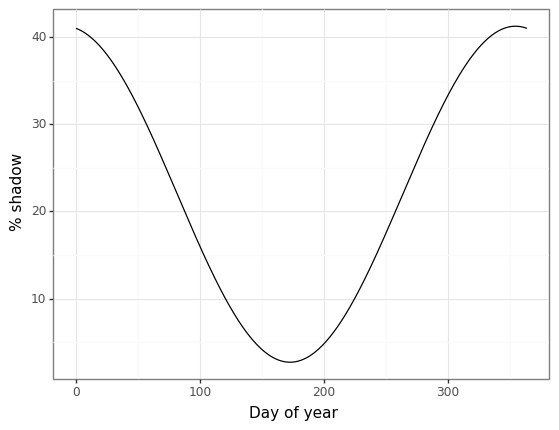

<ggplot: (103557089106)>


In [33]:
midday = df_resampled.loc[df_resampled['time'] == '11:45'].copy()
display(midday)

# The highest sun elevation (smallest shadow, summer solstice) is on the 21st of June
# The lowest sun elevation (largest shadow, winter solstice) is on the 22st of December
doy_summer_solstice = pd.Series(pd.to_datetime('2019-06-21', format='%Y-%m-%d')).dt.strftime('%j').astype(float).values[0]
doy_winter_solstice = pd.Series(pd.to_datetime('2019-12-22', format='%Y-%m-%d')).dt.strftime('%j').astype(float).values[0]

# Fit a cosine curve. The offset of the highest and lowest point of the sun from the end and middle of the year is:
offset = np.mean([365/2-doy_summer_solstice, 365-doy_winter_solstice])

# Define x and y data for curve fitting
x_data = list(midday['doy'])
y_data = list(midday['shadow'])

# Define a cosine-based function with two parameters
# a and b represent the amplitude, and phase shift, respectively.
def shadow_perc_from_doy(doy, a, c):
    return a * np.cos(np.radians((doy-365/2+offset)*360/364)) + c

param, _ = curve_fit(shadow_perc_from_doy, x_data, y_data)
print('Parameters:', param)

print(shadow_perc_from_doy(82, param[0], param[1]))
#print(shadow_perc_from_doy(201, param[0], param[1]))

# define a range of input values to plot the curve
x_plot = np.arange(0, 365, 1)
y_plot = shadow_perc_from_doy(x_plot, param[0], param[1])

plt = ggplot()
plt = plt + geom_line(aes(x=x_plot, y=y_plot))
plt = plt + labs(x='Day of year', y='% shadow')
plt = plt + theme_bw()
print(plt)

In [34]:
# Create day-of-year column
meteo_stn['doy'] = meteo_stn['DateTime'].dt.strftime('%j').astype(int)
# Convert time from 60min-base to decimal
meteo_stn['time'] = meteo_stn['DateTime'].dt.strftime('%H').astype(float) + meteo_stn['DateTime'].dt.strftime('%M').astype(float)/60
# Detect sunrise & sunset time
yearly_meteo_stn = meteo_stn.groupby(['doy','time']).max()
yearly_meteo_stn.reset_index(inplace=True)
yearly_meteo_stn.drop(['RH_perc','Ta_C','u_ms'], axis=1, inplace=True)

sun_df = yearly_meteo_stn.loc[yearly_meteo_stn['Eg_Wm2'].gt(0)].groupby('doy', sort=False).agg(['first', 'last'])
sun_df.reset_index(inplace=True)
sun_df.columns = ['_'.join(col).strip('_') for col in sun_df.columns.values]
sun_df.drop(['DateTime_first','DateTime_last','Eg_Wm2_first', 'Eg_Wm2_last'], axis=1, inplace=True)

display(sun_df.loc[sun_df['doy'] == 110])

,doy,time_first,time_last
109,110,5.25,18.25


In [35]:
# Add the minimum shade
sun_df['min_shade'] = shadow_perc_from_doy(sun_df['doy'], param[0], param[1])
# Range of daytime hours
sun_df['range_dt'] = sun_df['time_last'] - sun_df['time_first']

display(sun_df.loc[sun_df['doy'] == 201])

,doy,time_first,time_last,min_shade,range_dt
200,201,5.25,18.75,4.942319,13.5


In [36]:
import warnings # To ignore warnings

sun_df['a'] = np.nan
sun_df['b'] = np.nan
sun_df['c'] = np.nan

for index, row in sun_df.iterrows():
    # Fit curve
    # Define x and y data for curve fitting
    sunrise = row['time_first']
    sunset  = row['time_last']
    min_shade = row['min_shade']

    # Define data for curve fitting
    x_data = [sunrise, sunset, sunrise+(sunset-sunrise)/2]
    y_data = [(100-pv_percent),(100-pv_percent),min_shade]

    # Define a cosine-based function with two parameters
    # a and b represent the amplitude, and phase shift, respectively.
    x_range = sunset - sunrise
    def shadow_cosine(hour, a, b, c):
        return a * np.cos(np.radians((hour+b)*180/x_range)) + c
    
    # Fit curve
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        param, _ = curve_fit(shadow_cosine, x_data, y_data)
    
    # Save data
    sun_df.loc[sun_df['doy'] == row['doy'],'a'] = param[0]
    sun_df.loc[sun_df['doy'] == row['doy'],'b'] = param[1]
    sun_df.loc[sun_df['doy'] == row['doy'],'c'] = param[2]
    pass

def shadow_perc_from_time(hour, a, b, c, x_range):
    shadow_perc = a * np.cos(np.radians((hour+b)*180/x_range)) + c
    shadow_perc = np.where(shadow_perc > (100-pv_percent), (100-pv_percent), shadow_perc) # Make it 50% if it's larger than 50
    return(shadow_perc)

#sun_df['test'] = shadow_perc_from_time(10, sun_df['a'], sun_df['b'], sun_df['c'], sun_df['range_dt'])
    
display(sun_df)
display(sun_df.loc[sun_df['doy'] == 180])

,doy,time_first,time_last,min_shade,range_dt,a,b,c
0,1,6.75,16.75,40.927492,10.0,8.072508,-21.75,49.0
1,2,6.75,16.75,40.866137,10.0,8.133863,-21.75,49.0
2,3,6.75,16.75,40.799149,10.0,8.200851,-21.75,49.0
3,4,6.75,17.25,40.726549,10.5,8.273451,-22.50,49.0
4,5,6.75,17.25,40.648358,10.5,8.351642,-22.50,49.0
...,...,...,...,...,...,...,...,...
360,361,6.75,16.75,41.116248,10.0,7.883752,-21.75,49.0
361,362,6.75,16.75,41.077588,10.0,7.922412,-21.75,49.0
362,363,6.75,16.75,41.033233,10.0,7.966767,-21.75,49.0
363,364,6.75,16.75,40.983196,10.0,8.016804,-21.75,49.0


,doy,time_first,time_last,min_shade,range_dt,a,b,c
179,180,4.75,18.75,2.847416,14.0,46.152584,58.25,49.0


In [37]:
# For each day, add the factors
perc_all_nadir = meteo_stn[['DateTime','time','doy']].merge(sun_df, on=['doy'], how='left')

# Calculate percentages
perc_all_nadir['shadow'] = shadow_perc_from_time(perc_all_nadir['time'],
                                           perc_all_nadir['a'],
                                           perc_all_nadir['b'],
                                           perc_all_nadir['c'],
                                           perc_all_nadir['range_dt'])

# Remove night-time
perc_all_nadir.loc[(perc_all_nadir['time'] < perc_all_nadir['time_first']) | (perc_all_nadir['time'] > perc_all_nadir['time_last']), 'shadow'] = np.nan

# Add panel percentage
perc_all_nadir['panel'] = pv_percent
perc_all_nadir.loc[(perc_all_nadir['time'] < perc_all_nadir['time_first']) | (perc_all_nadir['time'] > perc_all_nadir['time_last']), 'panel'] = np.nan

# Calculate soil percentage
perc_all_nadir['soil'] = 100 - perc_all_nadir['shadow'] - perc_all_nadir['panel']

# Keep only relevant columns
perc_all_nadir = perc_all_nadir[['DateTime', 'panel', 'shadow', 'soil']]

# Save the data
perc_all_nadir.to_csv(output_path + 'PV_percentages.csv', index=False)


# Show some of it, for an example
display(perc_all_nadir.loc[(perc_all_nadir['DateTime'] >= '2018-07-01 04:00') & (perc_all_nadir['DateTime'] <= '2018-07-01 18:00')])

,DateTime,panel,shadow,soil
8694,2018-07-01 04:15:00,NaN,NaN,NaN
8695,2018-07-01 04:45:00,51.0,49.000000,0.000000
8696,2018-07-01 05:15:00,51.0,43.843119,5.156881
8697,2018-07-01 05:45:00,51.0,38.751088,10.248912
8698,2018-07-01 06:15:00,51.0,33.787944,15.212056
8699,2018-07-01 06:45:00,51.0,29.016099,19.983901
8700,2018-07-01 07:15:00,51.0,24.495564,24.504436
8701,2018-07-01 07:45:00,51.0,20.283187,28.716813
8702,2018-07-01 08:15:00,51.0,16.431940,32.568060
8703,2018-07-01 08:45:00,51.0,12.990255,36.009745


## Trigonometric calculations with position of the sun (no shade percentages)

In [38]:
# Assume trigonometric calculations based on position of the sun, i.e. shade does not count:
# Normalise area based on "no shade" scenario

perc_all = perc_all_nadir.copy()

# "Flatten" the pv panels
perc_all['panel_flat'] = perc_all['panel'] / np.cos(np.radians(panel_angle))

# Normalise the % to 100%, because sometimes it only reaches 96% total
perc_all['total'] = perc_all['panel_flat'] + perc_all['soil']
perc_all['panel_norm']  = perc_all['panel_flat'] * 100 / perc_all['total']
perc_all['soil_norm']   = perc_all['soil'] * 100 / perc_all['total']
perc_all.drop(['total'], axis=1, inplace=True)

# Show some data
#display(perc_all.loc[(perc_all['DateTime'] >= '2018-07-01 04:00') & (perc_all['DateTime'] <= '2018-07-01 18:00')])

In [48]:
ketura = ketura_df.copy()

# Fix bad SW values
ketura.loc[ketura['SW_IN_merge'] < 0, 'SW_IN_merge'] = 0
ketura.loc[ketura['SW_OUT_merge'] < 0, 'SW_OUT_merge'] = 0
ketura.loc[ketura['SW_IN_merge'] <= 0, 'SW_OUT_merge'] = 0

# Re-calculate albedo from SW measurements (relevant for the desert)
ketura['albedo'] = np.nan
ketura['albedo'] = ketura['SW_OUT_merge'] / ketura['SW_IN_merge']

# Extract desert albedo & rename. This will be used for the soil & shade fractions of the PV field
desert_albedo = ketura.loc[ketura['Ecosystem'] == 'Desert background',['time','Season','albedo']].copy()
desert_albedo.rename({'albedo': 'albedo_soil'}, axis=1, inplace=True)

# group by time and average to make diurnals
desert_albedo = desert_albedo.groupby(['time', 'Season']).mean()
desert_albedo.reset_index(inplace=True)

# Add percentages of panels, soil, shade for each season
ketura = ketura.merge(perc_all, how='left',  on=['DateTime'])

# Merge desert soil albedo
ketura = ketura.merge(desert_albedo, how='left',  on=['Season','time'])

# Calculate PV field albedo, use the different albedos
ketura.loc[ketura['Ecosystem'] == 'PV field', 'albedo_no_shade'] = ketura.loc[ketura['Ecosystem'] == 'PV field', 'albedo_soil'] \
                                                        * ketura.loc[ketura['Ecosystem'] == 'PV field', 'soil_norm'] \
                                                        + albedo_pv \
                                                        * ketura.loc[ketura['Ecosystem'] == 'PV field', 'panel_norm']

# Convert albedo to fraction, not %
ketura['albedo_no_shade'] = ketura['albedo_no_shade']/100

# Save
albedo_final = ketura[['DateTime', 'Season', 'Ecosystem', 'SW_IN_merge',
                       'panel', 'shadow', 'soil', 'panel_flat',
                       'panel_norm', 'soil_norm', 'albedo_soil', 'albedo_no_shade']]
albedo_final.to_csv(output_path + 'PV_percentages.csv', index=False) # Note: We're overwriting the previous file here

In [49]:
def weighted_avg_and_std(values, weights):
    values = np.ma.masked_invalid(values)
    # Return the weighted average and standard deviation.
    average = np.ma.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.ma.average((values-average)**2, weights=weights)
    
    maximum = np.max(values)
    minimum = np.min(values)
    return (average, np.sqrt(variance), maximum, minimum)

print('Spring:')
spring = ketura.loc[(ketura['Ecosystem'] == 'PV field') & (ketura['Season'] == 'Spring')]
print(weighted_avg_and_std(spring['albedo_no_shade'], spring['SW_IN_merge']))
print()

print('Summer:')
summer = ketura.loc[(ketura['Ecosystem'] == 'PV field') & (ketura['Season'] == 'Summer')]
print(weighted_avg_and_std(summer['albedo_no_shade'], summer['SW_IN_merge']))
print()

print('Autumn:')
autumn = ketura.loc[(ketura['Ecosystem'] == 'PV field') & (ketura['Season'] == 'Autumn')]
print(weighted_avg_and_std(autumn['albedo_no_shade'], autumn['SW_IN_merge']))

Spring:
(0.1450242004898083, 0.01779008522384073, 0.16228018236442956, 0.05)

Summer:
(0.16867474909953498, 0.025799037248112434, 0.18962625303698782, 0.05)

Autumn:
(0.10948982520886631, 0.01226330912250945, 10.219013207700756, 0.05)
